видео https://www.youtube.com/watch?v=NlNLtPqlCK0&t=4417s

# A Gentle Introduction to Recommender Systems with Implicit Feedback

https://implicit.readthedocs.io/en/latest/quickstart.html - документация implicit

https://jessesw.com/Rec-System/ - Articles about Implicit

https://github.com/benfred/implicit

The dataset is called “Online Retail” and is found here.
https://archive.ics.uci.edu/ml/datasets/Online+Retail

## Processing the Data

In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from tqdm.notebook import tqdm
#from scipy.sparse.linalg import spsolve

In [2]:
#!pip3 install xlrd

In [3]:
#website_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
#retail_data = pd.read_excel(website_url) # This may take a couple minutes

In [4]:
local = False
if local: 
    df = pd.read_csv("Online Retail.csv",sep=';')
else:
    # чтение с googl диска
    url = "https://drive.google.com/file/d/1jqVVZc2GuQRNfEUX-yVB7bEqaLkMZYL0/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df = pd.read_csv(path,sep=';')

In [5]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 8:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01.12.2010 8:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 8:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 8:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 8:26,"3,39",17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09.12.2011 12:50,"0,85",12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09.12.2011 12:50,"2,1",12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09.12.2011 12:50,"4,15",12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09.12.2011 12:50,"4,15",12680.0,France


In [6]:
list_col = []
for col in df.columns.str.lower():
    list_col.append(col.replace(' ','_'))
df.columns = list_col

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  object 
 6   customerid   406829 non-null  float64
 7   country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [8]:
dictionary = {column: column.lower() for column in df.columns}
dictionary['stockcode'] = 'stock_id'
dictionary['customerid'] = 'customer_id'
dictionary['invoiceno'] = 'invoice_number'
dictionary['invoicedate'] = 'invoice_date'
df = df.rename(columns=dictionary)

In [9]:
df = df.loc[pd.isnull(df.customer_id) == False]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   invoice_number  406829 non-null  object 
 1   stock_id        406829 non-null  object 
 2   description     406829 non-null  object 
 3   quantity        406829 non-null  int64  
 4   invoice_date    406829 non-null  object 
 5   unitprice       406829 non-null  object 
 6   customer_id     406829 non-null  float64
 7   country         406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


Before we make any sort of ratings matrix, it would be nice to have a lookup table that keeps track of each item ID along with a description of that item. Let’s make that now.

In [11]:
description_encoder = df[['stock_id', 'description']].drop_duplicates() # Only get unique item/description pairs
description_encoder['stock_id'] = description_encoder['stock_id'].astype(str) # Encode as strings for future lookup ease

In [12]:
description_encoder.head()

,stock_id,description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


This can tell us what each item is, such as that StockCode 71053 is a white metal lantern. Now that this has been created, we need to:

- Group purchase quantities together by stock code and item ID
- Change any sums that equal zero to one (this can happen if items were returned, but we want to indicate that the user actually purchased the item instead of assuming no interaction between the user and the item ever took place)
- Only include customers with a positive purchase total to eliminate possible errors
- Set up our sparse ratings matrix

This last step is especially important if you don’t want to have unnecessary memory issues! If you think about it, our matrix is going to contain thousands of items and thousands of users with a user/item value required for every possible combination. That is a LARGE matrix, so we can save a lot of memory by keeping the matrix sparse and only saving the locations and values of items that are not zero.

The code below will finish the preprocessing steps necessary for our final ratings sparse matrix:

In [13]:
df.head()

,invoice_number,stock_id,description,quantity,invoice_date,unitprice,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 8:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01.12.2010 8:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 8:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 8:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 8:26,"3,39",17850.0,United Kingdom


In [14]:
# Convert to int for customer ID
df['customer_id'] = df['customer_id'].astype(int) 

# Get rid of unnecessary info
df_cleaned = df[['stock_id', 'quantity', 'customer_id']]

# Group together
df_grouped_cleaned = df_cleaned.groupby(['customer_id', 'stock_id']).sum().reset_index() 

# Replace a sum of zero purchases with a one to indicate purchased
df_grouped_cleaned['quantity'].loc[df_grouped_cleaned['quantity'] == 0] = 1 

df_final = df_grouped_cleaned.query('quantity > 0') # Only get customers where purchase totals were positive

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
df_final

,customer_id,stock_id,quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40
...,...,...,...
267610,18287,84920,4
267611,18287,85039A,96
267612,18287,85039B,120
267613,18287,85040A,48


If we look at our final resulting matrix of grouped purchases, we see the following:

In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266723 entries, 0 to 267614
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  266723 non-null  int64 
 1   stock_id     266723 non-null  object
 2   quantity     266723 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.1+ MB


Instead of representing an explicit rating, the purchase quantity can represent a “confidence” in terms of how strong the interaction was. Items with a larger number of purchases by a customer can carry more weight in our ratings matrix of purchases.

Our last step is to create the sparse ratings matrix of users and items utilizing the code below:

In [17]:
#customers = list(np.sort(grouped_purchased.CustomerID.unique())) # Get our unique customers

# Get our unique customers
customers = list(df_final['customer_id'].unique())

# Get our unique products that were purchased
products = list(df_final['stock_id'].unique())

# All of our purchases
quantity = list(df_final['quantity']) 

In [18]:
len(customers)

4338

In [19]:
#quantity

In [20]:
# Get the associated row indices
rows = df_final['customer_id'].astype('category').cat.codes

# Get the associated column indices
cols = df_final['stock_id'].astype('category').cat.codes 

# sparse matrix
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

**sparse.csr_matrix user x item**

In [21]:
purchases_sparse

<4338x3664 sparse matrix of type '<class 'numpy.intc'>'
	with 266723 stored elements in Compressed Sparse Row format>

In [22]:
len(rows)

266723

In [23]:
series_customer_id = df_final['customer_id'].astype('category')
encoder_user_customer = (rows.to_frame()).join(series_customer_id.to_frame()).drop_duplicates()

encoder_user_customer.columns = ('user_id','customer_id')
encoder_user_customer

,user_id,customer_id
0,0,12346
1,1,12347
104,2,12348
126,3,12349
199,4,12350
...,...,...
267264,4333,18280
267274,4334,18281
267281,4335,18282
267293,4336,18283


In [24]:
series_stock_id = df_final['stock_id'].astype('category')
encoder_stock_item = (cols.to_frame()).join(series_stock_id.to_frame()).drop_duplicates()

encoder_stock_item.columns = ('item_id','stock_id')
encoder_stock_item['stock_id'] = encoder_stock_item['stock_id'].astype('category')
encoder_stock_item


,item_id,stock_id
0,1997,23166
1,25,16008
2,87,17021
3,130,20665
4,167,20719
...,...,...
257812,2391,23664
257958,482,21310
258861,2922,84613C
261194,2812,84206B


We have 4338 customers with 3664 items. For these user/item interactions, 266723 of these items had a purchase. In terms of sparsity of the matrix, that makes:

In [25]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

98.32190920694744

98.3% of the interaction matrix is sparse. For collaborative filtering to work, the maximum sparsity you could get away with would probably be about 99.5% or so. We are well below this, so we should be able to get decent results.

## Creating a Training and Validation Set

With collaborative filtering, that’s not going to work because you need all of the user/item interactions to find the proper matrix factorization. A better method is to hide a certain percentage of the user/item interactions from the model during the training phase chosen at random. Then, check during the test phase how many of the items that were recommended the user actually ended up purchasing in the end. Ideally, you would ultimately test your recommendations with some kind of A/B test or utilizing data from a time series where all data prior to a certain point in time is used for training while data after a certain period of time is used for testing.

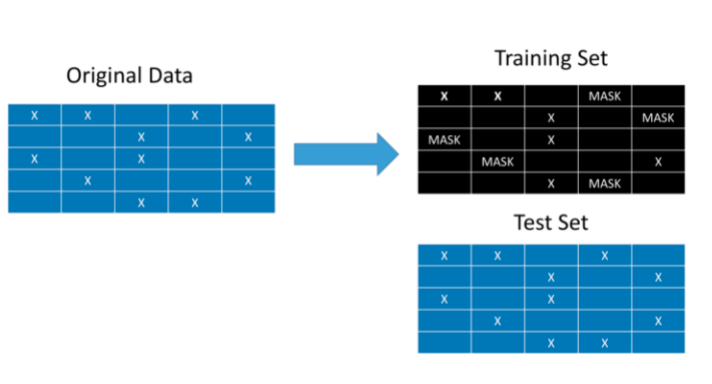

In [26]:
import random

In [27]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds))

In [28]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

In [29]:
product_train

<4338x3664 sparse matrix of type '<class 'numpy.intc'>'
	with 213378 stored elements in Compressed Sparse Row format>

In [30]:
product_test

<4338x3664 sparse matrix of type '<class 'numpy.intc'>'
	with 266723 stored elements in Compressed Sparse Row format>

## AlternatingLeastSquares

### Пример использования из документации библиотеки implicit

https://implicit.readthedocs.io/en/latest/quickstart.html

```Python
import implicit

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(item_user_data)

# recommend items for a user
user_items = item_user_data.T.tocsr()
recommendations = model.recommend(userid, user_items)

# find related items
related = model.similar_items(itemid)

```

### Метрика normalized_average_precision

In [31]:
def average_precision(actual, recommended, k=30):
    ap_sum = 0
    hits = 0
    for i in range(k):
        product_id = recommended[i] if i < len(recommended) else None
        if product_id is not None and product_id in actual:
            hits += 1
            ap_sum += hits / (i + 1)
    return ap_sum / k


def normalized_average_precision(actual, recommended, k=30):
    actual = set(actual)
    if len(actual) == 0:
        return 0.0

    ap = average_precision(actual, recommended, k=k)
    ap_ideal = average_precision(actual, list(actual)[:k], k=k)
    return ap / ap_ideal


## Модель

In [32]:
import implicit

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=20, regularization = 0.1, iterations = 50)

# train the model on a sparse matrix of item/user/confidence weights
item_user_data = (product_train.T).astype('float64')
model.fit(item_user_data)

user_items = product_test.tocsr().astype('float64') #item_user_data.T.tocsr()


  0%|          | 0/50 [00:00<?, ?it/s]

**recommend()**

Parameters:	
- userid (int) – The userid to calculate recommendations for
- user_items (csr_matrix) – A sparse matrix of shape (number_users, number_items). This lets us look up the liked items and their weights for the user. This is used to filter out items that have already been liked from the output, and to also potentially calculate the best items for this user.
- N (int, optional) – The number of results to return
- filter_already_liked_items (bool, optional) – When true, don’t return items present in the training set that were rated by the specificed user.
- filter_items (sequence of ints, optional) – List of extra item ids to filter out from the output
- recalculate_user (bool, optional) – When true, don’t rely on stored user state and instead recalculate from the passed in user_items

In [33]:
# recommend items for a user

m_ap=[]
for userid in tqdm(product_users_altered):
    #print(userid)
    recommendations = model.recommend(userid, user_items, N=30, filter_already_liked_items=False, recalculate_user=True)
    
    recommended_item_list = []
    for rec in recommendations:
        recommended_item_list.append(rec[0])
    
    train_item_list = []
    argwhere = np.argwhere(product_train[userid])
    for i in range(argwhere.shape[0]):
        train_item_list.append(argwhere[i][1])
        
    m_ap.append(normalized_average_precision(train_item_list,recommended_item_list,k=30))    

  0%|          | 0/4042 [00:00<?, ?it/s]

In [34]:
print(np.mean(m_ap))

0.20538146962058784


## TOP30

In [35]:
top_all = df_final.groupby('stock_id')['quantity'].sum().to_frame().sort_values(by='quantity', ascending=False).reset_index()
top_30 = top_all.head(30)
top_30['stock_id'] = top_30['stock_id'].astype('str')
encoder_stock_item['stock_id'] = encoder_stock_item['stock_id'].astype('str')

<ipython-input-35-47edad1853b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_30['stock_id'] = top_30['stock_id'].astype('str')


In [36]:
top_30.head()

,stock_id,quantity
0,84077,53217
1,22197,48713
2,85099B,45106
3,84879,35316
4,85123A,34208


In [37]:
dummy_recommended = top_30.merge(encoder_stock_item, how='left', left_on = 'stock_id', right_on = 'stock_id')['item_id']
dummy_recommended_list = dummy_recommended.to_list()
print(dummy_recommended_list)

[2803, 1088, 3218, 3058, 3232, 423, 1919, 1352, 1469, 910, 76, 1069, 12, 877, 1257, 2033, 3129, 170, 1331, 3220, 3096, 1543, 2986, 985, 2593, 1802, 1794, 424, 1046, 1482]


In [38]:
m_ap=[]
for userid in tqdm(product_users_altered):
    train_item_list = []
    argwhere = np.argwhere(product_train[userid])
    for i in range(argwhere.shape[0]):
        train_item_list.append(argwhere[i][1])
        
    m_ap.append(normalized_average_precision(train_item_list, dummy_recommended_list, k=30)) 
    # проверка на 1
    #m_ap.append(normalized_average_precision(dummy_recommended_list, dummy_recommended_list, k=30))       
    # m_ap.append(normalized_average_precision(train_item_list, train_item_list, k=30))    

  0%|          | 0/4042 [00:00<?, ?it/s]

In [39]:
print(np.mean(m_ap))

0.02506592857955788


## Cosine item2item

In [40]:
model = implicit.nearest_neighbours.CosineRecommender(K=1) # рекоммендуем К товаров к купленному
item_user_data = (product_train.T).astype('float64')

model.fit(item_user_data)

user_items = (product_test.tocsr()).astype('float64') #item_user_data.T.tocsr()

  0%|          | 0/3664 [00:00<?, ?it/s]

In [41]:
# recommend items for a user

m_ap=[]
for userid in tqdm(product_users_altered):
    #print(userid)
    recommendations = model.recommend(userid, user_items, N=30, filter_already_liked_items=False, recalculate_user=True)
    
    recommended_item_list = []
    for rec in recommendations:
        recommended_item_list.append(rec[0])
    
    train_item_list = []
    argwhere = np.argwhere(product_train[userid])
    for i in range(argwhere.shape[0]):
        train_item_list.append(argwhere[i][1])
        
    m_ap.append(normalized_average_precision(train_item_list,recommended_item_list,k=30))


  0%|          | 0/4042 [00:00<?, ?it/s]

In [42]:
print(np.mean(m_ap))

0.7281568413736496


## SVD

In [43]:
X_sparse = product_train

In [44]:
X_stored = X_sparse.tocsr()

In [45]:
from sklearn.decomposition import TruncatedSVD

In [46]:
svd = TruncatedSVD(n_components=128)
X_dense = svd.fit_transform(X_sparse)

In [47]:
from sklearn.neighbors import NearestNeighbors

In [48]:
num_neighbours=256
knn = NearestNeighbors(n_neighbors=num_neighbours, metric='cosine')
knn.fit(X_dense)

NearestNeighbors(metric='cosine', n_neighbors=256)

In [54]:
m_ap=[]
for userid in tqdm(product_users_altered):
    #print(userid)

    row_sparse = product_test[userid]
    row_dense = svd.transform(row_sparse)
    knn_result = knn.kneighbors(row_dense, n_neighbors=num_neighbours)
    neighbours = knn_result[1]
    scores = np.asarray(X_stored[neighbours[0]].sum(axis=0)[0]).flatten()
    top_indices = np.argsort(-scores)
    
    recommended_item_list = []
    for rec in top_indices[:30]:
        recommended_item_list.append(rec)
    
    train_item_list = []
    argwhere = np.argwhere(product_train[userid])
    for i in range(argwhere.shape[0]):
        train_item_list.append(argwhere[i][1])
        
    m_ap.append(normalized_average_precision(train_item_list, recommended_item_list,k=30))

    #break

  0%|          | 0/4042 [00:00<?, ?it/s]

In [55]:
print(np.mean(m_ap))

0.20576705529293593


In [56]:
#print(row_sparse.shape)

In [57]:
#len(row_dense)

In [58]:
#row_dense.shape